# Análisis de tweets políticos

### Descripción

Este proyecto consiste en un análisis integral de la huella digital de líderes políticos estadounidenses a través de sus interacciones en redes sociales. Utilizaremos técnicas de procesamiento de datos masivos para examinar la relación entre el perfil del mandatario (antigüedad, verificación y alcance) y el impacto de su discurso (retweets y favoritos). Los hallazgos permitirán identificar patrones de comunicación exitosos y anomalías en la divulgación de información pública. La audiencia principal de este estudio son analistas de comunicación política, periodistas de datos y organizaciones dedicadas a la transparencia gubernamental. El objetivo final es proporcionar una visión clara sobre cómo el poder político se traduce en influencia digital.

### Preguntas (Questions)

1. ¿Existe una correlación directa entre la antigüedad de la cuenta de un político y su número total de seguidores actuales?
2. ¿Qué estados (location) presentan los niveles de engagement más altos (promedio de retweets por tweet) en sus representantes?
3. ¿Cómo varía la frecuencia de publicación de los usuarios verificados en comparación con los no verificados durante periodos de alta actividad?

### Hipótesis (Hypothesis)

1. **Hipótesis de Antigüedad:** Las cuentas creadas antes del año 2012 poseen una base de seguidores significativamente mayor, independientemente de su frecuencia de posteo actual, debido a la ventaja de "primer movimiento" en la plataforma.
2. **Hipótesis de Ubicación:** Los usuarios cuya localización está vinculada a estados con alta densidad poblacional (como Nueva York o California) reciben un 30% más de retweets que aquellos de estados rurales, debido al volumen de audiencia local.
3. **Hipótesis de Verificación:** Las cuentas verificadas mantienen una consistencia de publicación mayor (desviación típica menor en el tiempo entre tweets) que las cuentas no verificadas.

### 1. Importación de librerías

In [36]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# 1. Quitar el límite de columnas en el resumen .info(), por si acaso tuviera muchas columas
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_colwidth', None) #mostrar todo el contenido de la fila
pd.set_option('display.max_columns', None)

### 2. Visión general de los datasets

tweets.json

In [2]:
#Concexión con duckdb para poder hacer consultas SQL 
con = duckdb.connect()

#Creación de la tabla con la información de los datasets
con.execute("CREATE OR REPLACE VIEW tweets AS SELECT * FROM read_json_auto('tweets.json', union_by_name=True, sample_size=100000)")

#Consulta
query = """
SELECT * FROM tweets

"""
#Conversión a df
df_tweets = con.execute(query).df()

#Información general
df_tweets.info(verbose=True, show_counts=True)
display(df_tweets.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243370 entries, 0 to 1243369
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   contributors               0 non-null        object 
 1   coordinates                2734 non-null     object 
 2   created_at                 1243370 non-null  int64  
 3   display_text_range         1243370 non-null  object 
 4   entities                   1243370 non-null  object 
 5   favorite_count             1243370 non-null  int64  
 6   favorited                  1243370 non-null  bool   
 7   geo                        2734 non-null     object 
 8   id                         1243370 non-null  int64  
 9   id_str                     1243370 non-null  object 
 10  in_reply_to_screen_name    65411 non-null    object 
 11  in_reply_to_status_id      54146 non-null    Int64  
 12  in_reply_to_status_id_str  54146 non-null    object 
 13  in_reply_to_

,contributors,coordinates,created_at,display_text_range,entities,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,retweet_count,retweeted,screen_name,source,text,truncated,user_id,possibly_sensitive,extended_entities,quoted_status_id,quoted_status_id_str
0,None,<NA>,1217870931,"[0, 74]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': [], 'media': None}",0,False,<NA>,877418565,877418565,None,<NA>,None,<NA>,None,False,en,<NA>,0,False,JohnBoozman,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",On a conference call about a weekend trip to Iraq to visit Arkansas troops,False,5558312,<NA>,<NA>,<NA>,None
1,None,<NA>,1218049485,"[0, 25]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': [], 'media': None}",0,False,<NA>,879618172,879618172,None,<NA>,None,<NA>,None,False,nl,<NA>,0,False,JohnBoozman,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Being interviewed by KTHV,False,5558312,<NA>,<NA>,<NA>,None
2,None,<NA>,1218054936,"[0, 65]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': [], 'media': None}",0,False,<NA>,879695803,879695803,None,<NA>,None,<NA>,None,False,en,<NA>,0,False,JohnBoozman,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Being interviewed by KARN on his Arkansas World Trade Center trip,False,5558312,<NA>,<NA>,<NA>,None
3,None,<NA>,1218117172,"[0, 37]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': [], 'media': None}",0,False,<NA>,880393665,880393665,None,<NA>,None,<NA>,None,False,en,<NA>,0,False,JohnBoozman,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>","On KWHN in Fort Smith, that's 1320 AM",False,5558312,<NA>,<NA>,<NA>,None
4,None,<NA>,1218121925,"[0, 90]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': [], 'media': None}",0,False,<NA>,880474266,880474266,None,<NA>,None,<NA>,None,False,en,<NA>,0,False,JohnBoozman,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Attending a Military of the Purple Heart Ceremony at the VA Medical Center in Fayetteville,False,5558312,<NA>,<NA>,<NA>,None


users.json

In [3]:
#Creación de la tabla con la información de los datasets
con.execute("CREATE OR REPLACE VIEW users AS SELECT * FROM read_json_auto('users.json', union_by_name=True, sample_size=100000)")

#Consulta
query = """
SELECT * FROM users

"""
df_users = con.execute(query).df()
df_users.info()
display(df_users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   contributors_enabled                548 non-null    bool  
 1   created_at                          548 non-null    object
 2   default_profile                     548 non-null    bool  
 3   default_profile_image               548 non-null    bool  
 4   description                         548 non-null    object
 5   entities                            545 non-null    object
 6   favourites_count                    548 non-null    int64 
 7   follow_request_sent                 548 non-null    bool  
 8   followers_count                     548 non-null    int64 
 9   following                           548 non-null    bool  
 10  friends_count                       548 non-null    int64 
 11  geo_enabled                         548 non-null    bool  

,contributors_enabled,created_at,default_profile,default_profile_image,description,entities,favourites_count,follow_request_sent,followers_count,following,friends_count,geo_enabled,has_extended_profile,id,id_str,is_translation_enabled,is_translator,lang,listed_count,location,name,notifications,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_banner_url,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,protected,screen_name,statuses_count,time_zone,translator_type,url,utc_offset,verified
0,False,1417384037,True,False,"Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed ""-BW"" come directly from Governor.","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'gov.alaska.gov', 'expanded_url': 'http://gov.alaska.gov', 'indices': [0, 22], 'url': 'http://t.co/NO67LyZvUR'}]}}",115,False,5870,False,550,True,False,2915095729,2915095729,False,False,en,190,Alaska,Governor Bill Walker,False,C0DEED,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/2915095729/1417385137,http://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg,https://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg,1DA1F2,C0DEED,DDEEF6,333333,True,False,AkGovBillWalker,1642,None,none,http://t.co/NO67LyZvUR,<NA>,True
1,False,1240239576,False,False,"U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'amyklobuchar.com', 'expanded_url': 'http://www.amyklobuchar.com', 'indices': [0, 22], 'url': 'http://t.co/mGGFBfggto'}]}}",24,False,170717,False,91751,False,False,33537967,33537967,False,False,en,2493,,Amy Klobuchar,False,026113,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,None,http://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg,https://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg,026113,F6D73F,89BCEE,3D3C3D,True,False,amyklobuchar,5567,Central Time (US & Canada),none,http://t.co/mGGFBfggto,-18000,True
2,False,1366837593,False,False,"Congressman for Maryland's 4th Congressional District, former Army Aviator, father and husband","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'anthonybrown.com', 'expanded_url': 'http://www.anthonybrown.com', 'indices': [0, 23], 'url': 'https://t.co/NYPWOVmoAx'}]}}",90,False,6067,False,369,True,True,1378000346,1378000346,False,False,en,170,"Mitchellville, MD",Anthony G. Brown,False,184466,http://pbs.twimg.com/profile_background_images/884068111/76c403a1354bd42620a38d317f6d0a23.jpeg,https://pbs.twimg.com/profile_background_images/884068111/76c403a1354bd42620a38d317f6d0a23.jpeg,True,https://pbs.twimg.com/profile_banners/1378000346/1479909083,http://pbs.twimg.com/profile_images/801128012573970433/2MGZIRal_normal.jpg,https://pbs.twimg.com/profile_images/801128012573970433/2MGZIRal_normal.jpg,6B2E13,FFFFFF,DDEEF6,333333,False,False,AnthonyBrownMD4,1878,Eastern Time (US & Canada),none,https://t.co/NYPWOVmoAx,-14400,True
3,False,1300739574,False,False,"Husband of 43 yrs, Dad of 4, Papaw of 6. Lifelong Arkansan. Governor of Arkansas. Former Congressman, Admin. of DEA, Under Sec. of Homeland Security.","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'governor.arkansas.gov', 'expanded_url': 'http://www.governor.arkansas.gov', 'indices': [0, 23], 'url': 'https://t.co/b38CUNlZHi'}]}}",440,False,25747,False,598,True,True,269992801,269992801,False,False,en,420,Arkansas,Gov. Asa Hutchinson,False,C0DEED,http://pbs.twimg.com/profile_background_images/378800000022012499/f440cc71434509f7036d04f5ed7cd67e.jpeg,https://pbs.twimg.com/profile_background_images/378800000

### 3. Limpieza de datos

Primero vamos a solucionar la columna entities de ambos datasets. Como vemos, esta columna representa un "objeto dentro de otro objeto"

In [4]:
df_users["entities"].head()


0                       {'description': {'urls': []}, 'url': {'urls': [{'display_url': 'gov.alaska.gov', 'expanded_url': 'http://gov.alaska.gov', 'indices': [0, 22], 'url': 'http://t.co/NO67LyZvUR'}]}}
1               {'description': {'urls': []}, 'url': {'urls': [{'display_url': 'amyklobuchar.com', 'expanded_url': 'http://www.amyklobuchar.com', 'indices': [0, 22], 'url': 'http://t.co/mGGFBfggto'}]}}
2              {'description': {'urls': []}, 'url': {'urls': [{'display_url': 'anthonybrown.com', 'expanded_url': 'http://www.anthonybrown.com', 'indices': [0, 23], 'url': 'https://t.co/NYPWOVmoAx'}]}}
3    {'description': {'urls': []}, 'url': {'urls': [{'display_url': 'governor.arkansas.gov', 'expanded_url': 'http://www.governor.arkansas.gov', 'indices': [0, 23], 'url': 'https://t.co/b38CUNlZHi'}]}}
4         {'description': {'urls': []}, 'url': {'urls': [{'display_url': 'austinscott.house.gov', 'expanded_url': 'http://austinscott.house.gov', 'indices': [0, 22], 'url': 'http://t.co/GQwXIh

De este modo, para la tabla users vamos a crear una nueva tabla extrayendo la información más importante de esta columna(la URL del sitio web oficial). Para ello, mantendremos las columnas originales de la tabla y añadiremos una nueva columna -> "official_website", que rellenaremos con la información de dentro del diccionario a través de: entities.url.urls[0].expanded_url

In [5]:
# 1. Creamos (o reemplazamos) la tabla con las nuevas columnas extraídas
con.execute("""
CREATE OR REPLACE TABLE clean_users AS
SELECT 
    *, -- Mantenemos todas las columnas originales
    -- Extraemos la URL oficial
    entities.url.urls[1].expanded_url AS official_website,
FROM users;
""")

# 2. Actualizamos nuestro DataFrame de Pandas para ver los resultados
df_users = con.execute("SELECT * FROM clean_users").df()

# 3. Eliminación de la columna original que ya no nos sirve
df_users = df_users.drop(columns=['entities'])

In [6]:
# 4. Verificamos las nuevas columnas
df_users[['screen_name', 'official_website']].head()

,screen_name,official_website
0,AkGovBillWalker,http://gov.alaska.gov
1,amyklobuchar,http://www.amyklobuchar.com
2,AnthonyBrownMD4,http://www.anthonybrown.com
3,AsaHutchinson,http://www.governor.arkansas.gov
4,AustinScottGA08,http://austinscott.house.gov


In [7]:
df_tweets["entities"].head()

0    {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': [], 'media': None}
1    {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': [], 'media': None}
2    {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': [], 'media': None}
3    {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': [], 'media': None}
4    {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': [], 'media': None}
Name: entities, dtype: object

In [8]:
# 1. Creamos la tabla limpia extrayendo los campos clave
con.execute("""
CREATE OR REPLACE TABLE clean_tweets AS
SELECT 
    *, -- Mantenemos lo demás
    text,
    entities.hashtags[1].text AS main_hashtag -- Extrae el texto del primer hashtag
FROM tweets
""")

# 2. Traemos el resultado a Pandas
df_tweets = con.execute("SELECT * FROM clean_tweets").df()

# 3. Eliminamos la columna original 'entities' que ya no necesitamos
df_tweets = df_tweets.drop(columns=['entities'])

df_tweets[['text', 'main_hashtag']].head()

,text,main_hashtag
0,On a conference call about a weekend trip to Iraq to visit Arkansas troops,None
1,Being interviewed by KTHV,None
2,Being interviewed by KARN on his Arkansas World Trade Center trip,None
3,"On KWHN in Fort Smith, that's 1320 AM",None
4,Attending a Military of the Purple Heart Ceremony at the VA Medical Center in Fayetteville,None


De este modo, hemos conseguido desanidar la columna entities en ambos datasets seleccionando la información más importante. 

A continuación, vamos a solucionar el problema de la columna created_at. Como vemos, el valor de la columna created_at expresa está en la unidad Unix Timestamp o Epoch Time (total de segundos transcurridos desde 1 de enero de 1970). Debemos tranformarlo para lograr una mejor interpretación del tiempo de creación de los usuarios y de publicación de los tweets. Para ello: 

In [9]:
# 1. Creamos la tabla limpia extrayendo los campos clave
con.execute("""
CREATE OR REPLACE TABLE clean_tweets AS
SELECT 
    *, -- Mantenemos lo demás
    CAST(to_timestamp(created_at) AS DATE) AS created_at_date
FROM tweets
""")

# 2. Traemos el resultado a Pandas
df_tweets = con.execute("SELECT * FROM clean_tweets").df()

# 3. Eliminamos la columna original 'entities' que ya no necesitamos
df_tweets = df_tweets.drop(columns=['created_at'])

df_tweets["created_at_date"].head()


0   2008-08-04
1   2008-08-06
2   2008-08-06
3   2008-08-07
4   2008-08-07
Name: created_at_date, dtype: datetime64[us]

In [10]:
#Comprobamos que hemos cambiado el tipo de dato
print(df_tweets["created_at_date"].dtype)

datetime64[us]


Repetimos la operación para el dataset de users: 

In [11]:
# 1. Creamos (o reemplazamos) la tabla con las nuevas columnas extraídas
con.execute("""
CREATE OR REPLACE TABLE clean_users AS
SELECT 
    *, 
    CASE 
        -- 1. Intentamos ver si es un número (Epoch)
        WHEN TRY_CAST(created_at AS BIGINT) IS NOT NULL 
            THEN CAST(to_timestamp(CAST(created_at AS BIGINT)) AS DATE)
        
        -- 2. Si es texto, limpiamos las posibles comillas dobles y parseamos
        ELSE 
            CAST(strptime(
                trim(CAST(created_at AS VARCHAR), '"'), -- Quitamos las comillas "
                '%a %b %d %H:%M:%S +0000 %Y'
            ) AS DATE)
    END AS created_at_date
FROM users
""")

# 2. Actualizamos nuestro DataFrame de Pandas para ver los resultados
df_users = con.execute("SELECT * FROM clean_users").df()

# 3. Eliminación de la columna original que ya no nos sirve
df_users = df_users.drop(columns=['created_at'])

# 4. Comprobación
df_users["created_at_date"].head()

0   2014-11-30
1   2009-04-20
2   2013-04-24
3   2011-03-21
4   2011-01-06
Name: created_at_date, dtype: datetime64[us]

A continuación, vamos a proceder con la eliminación de los duplicados. Para ello, cogeremos el identificador de cada usuario (id_str) y nos quedaremos con aquellos que solo aparezcan una vez y, en caso de que aparezcan más de una, con la entrada más nueva (ordenados de forma DESC):

In [12]:
# 1. Creamos la tabla definitiva deduplicada
con.execute("""
CREATE OR REPLACE TABLE users_final AS
SELECT DISTINCT ON (id_str) 
    * FROM clean_users 
ORDER BY id_str, created_at_date DESC
""")

# 2. Obtenemos las métricas para tu informe
total_inicial = con.execute("SELECT COUNT(*) FROM clean_users").fetchone()[0]
total_final = con.execute("SELECT COUNT(*) FROM users_final").fetchone()[0]
duplicados_eliminados = total_inicial - total_final

print(f"--- REPORTE DE DEDUPLICACIÓN ---")
print(f"Registros procesados: {total_inicial}")
print(f"Usuarios únicos conservados: {total_final}")
print(f"Duplicados eliminados: {duplicados_eliminados}")

#Creamos el dataframe
df_users_final = con.execute("SELECT * FROM users_final").df()

--- REPORTE DE DEDUPLICACIÓN ---
Registros procesados: 548
Usuarios únicos conservados: 548
Duplicados eliminados: 0


In [13]:
# 1. Creamos la tabla definitiva de tweets eliminando duplicados por id_str
con.execute("""
CREATE OR REPLACE TABLE tweets_final AS
SELECT DISTINCT ON (id_str) 
    * FROM clean_tweets 
ORDER BY id_str, created_at_date DESC
""")

# 2. Calculamos las métricas de limpieza para tu informe PDF
stats_tweets = con.execute("""
    SELECT 
        (SELECT COUNT(*) FROM clean_tweets) as total_antes,
        (SELECT COUNT(*) FROM tweets_final) as total_despues
""").df()

antes = stats_tweets['total_antes'][0]
despues = stats_tweets['total_despues'][0]
eliminados = antes - despues

print(f"--- REPORTE DE DUPLICACIÖN: ---")
print(f"Registros originales: {antes}")
print(f"Tweets únicos conservados: {despues}")
print(f"Duplicados eliminados: {eliminados}")

# 3. Traemos el DataFrame final a Pandas para el análisis
df_tweets_final = con.execute("SELECT * FROM tweets_final").df()

--- REPORTE DE DUPLICACIÖN: ---
Registros originales: 1243370
Tweets únicos conservados: 1243370
Duplicados eliminados: 0


No había ni usuarios ni tweets duplicados. Por último, quedará saber como gestionar el tema de los missing values en las columnas de interés (aquellas que nos ayudurán a responder a nuestras preguntas y testear las hipótesis).
Para ello: 

In [14]:
# Actualizamos la tabla de usuarios con texto normalizado
con.execute("""
CREATE OR REPLACE TABLE users_final AS
SELECT 
    * EXCLUDE (location, description), -- Mantenemos todo menos las originales
    NULLIF(TRIM(location), '') AS location,
    NULLIF(TRIM(description), '') AS description
FROM users_final
""")

# Actualizamos la tabla de tweets 
con.execute("""
CREATE OR REPLACE TABLE tweets_final AS
SELECT 
    * EXCLUDE (text),
    NULLIF(TRIM(text), '') AS text
FROM tweets_final
""")

# Verificamos cuántos nulos REALES hay ahora
reporte_nulos = con.execute("""
    SELECT 
        COUNT(*) - COUNT(location) as nulos_en_location,
        COUNT(*) - COUNT(description) as nulos_en_description
    FROM users_final
""").df()

print("Reporte de Nulos Reales (Post-Limpieza):")
display(reporte_nulos)

Reporte de Nulos Reales (Post-Limpieza):


,nulos_en_location,nulos_en_description
0,134,9


De acuerdo, a continuación vamos a crear unas nuevas tablas con la información que necesitamos para aceptar o rechazar nuestras hipótesis. De este modo, nos será más fácil actuar sobre unas pocas columnas: 

In [15]:
# 1. Creamos la tabla física en DuckDB con las columnas filtradas
con.execute("""
CREATE OR REPLACE TABLE users_analysis AS
SELECT 
    id_str,
    screen_name,
    followers_count,
    created_at_date AS account_creation_date, 
    location,                                 
    verified,                                   
FROM users_final;
""")

# 2. Ahora cargamos en el DataFrame 
df_users_analysis = con.execute("SELECT * FROM users_analysis").df()

# 3. Verificamos que solo existan esas 6 columnas
print(f"Columnas actuales: {df_users_analysis.columns.tolist()}")
df_users_analysis.head()

#Convertir a .csv para informe en PowerBI
df_users_analysis.to_csv('datos_politicos_limpios.csv', index=False, encoding='utf-8-sig')



Columnas actuales: ['id_str', 'screen_name', 'followers_count', 'account_creation_date', 'location', 'verified']


In [ ]:
# 1. Cargar datos
df = pd.read_csv('datos_politicos_limpios.csv')

# 2. Mapa de Estados (Nombre -> Código)
us_state_map = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC',
    'Washington DC': 'DC', 'Washington, D.C.': 'DC'
}

# Conjunto de códigos válidos para verificación rápida
valid_codes = set(us_state_map.values())

def get_state(location):
    if pd.isna(location) or location == "":
        return None
    
    text = str(location).strip()
    
    # A) Buscar nombres completos (ej: "Texas")
    for state_name, code in us_state_map.items():
        if re.search(r'\b' + re.escape(state_name) + r'\b', text, re.IGNORECASE):
            return code
            
    # B) Buscar abreviaturas de 2 letras mayúsculas (ej: "CA", "NY")
    # Busca al final o aisladas
    matches = re.findall(r'\b([A-Z]{2})\b', text)
    if matches:
        # Priorizar la última coincidencia válida (común en "City, STATE")
        for code in reversed(matches):
            if code in valid_codes:
                return code
    
    return None

# 3. Aplicar la limpieza
df['Location_State'] = df['location'].apply(get_state)

# 4.Rellenar nulos con 'DC' ya que la mayoría lo hacen desde el capitolio
df['Location_State'].fillna('DC', inplace=True)

# 5. Guardar
df.to_csv('datos_politicos_con_estados.csv', index=False)

C:\Users\ronge\AppData\Local\Temp\ipykernel_30156\3703155261.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Location_State'].fillna('DC', inplace=True)


In [16]:
# Creamos la tabla de tweets para análisis
con.execute("""
CREATE OR REPLACE TABLE tweets_analysis AS
SELECT 
    id_str AS tweet_id,
    user_id,
    retweet_count,
    favorite_count,
    created_at_date AS tweet_date,
    text
FROM tweets_final;
""")

df_tweets_analysis = con.execute("SELECT * FROM tweets_analysis").df()

# Verficamos las columnas
print(f"Columnas actuales: {df_tweets_analysis.columns.tolist()}")
df_tweets_analysis.head()

#Convertir a .csv para informe en PowerBI
df_tweets_analysis.to_csv('datos_tweets_limpios.csv', index=False, encoding='utf-8-sig')

Columnas actuales: ['tweet_id', 'user_id', 'retweet_count', 'favorite_count', 'tweet_date', 'text']


### Validación de hipótesis de ubicación

Ahora vamos al lidiar con los datos de la columna "location". Como hemmos visto anteriormente, tiene 134 valores nulos. No podemos borrarlos porque perderíamos los datos de esas filas, asi que vamos a incluirlos en una nueva categoría llamada "Unknown". Luego, como una de nuestras hipótesis esta relacionada con la densidad poblacional de los estados, vamos a estandarizar los valores, con el fin de luego poder sacar conclusiones más fácilmente. 

In [17]:
con.execute("""
CREATE OR REPLACE TABLE users_cleaned_location AS
SELECT 
    *,
    CASE 
        -- Paso 1: Manejo de Nulos
        WHEN location IS NULL THEN 'Unknown'
        
        -- Paso 2: Estandarización de California
        WHEN lower(location) LIKE '%ca%' 
          OR lower(location) LIKE '%california%' 
          OR lower(location) LIKE '%san francisco%' 
          OR lower(location) LIKE '%los angeles%' 
          THEN 'California'
        
        -- Paso 3: Estandarización de Nueva York
        WHEN lower(location) LIKE '%ny%' 
          OR lower(location) LIKE '%new york%' 
          OR lower(location) LIKE '%nyc%' 
          THEN 'New York'
        
        -- Paso 4: Otros estados de alta densidad 
        WHEN lower(location) LIKE '%tx%' OR lower(location) LIKE '%texas%' THEN 'Texas'
        WHEN lower(location) LIKE '%fl%' OR lower(location) LIKE '%florida%' THEN 'Florida'
        
        -- Paso 5: Todo lo demás
        ELSE 'Other'
    END AS state_group
FROM users_analysis;
""")

# Actualizamos el DataFrame
df_users_final = con.execute("SELECT * FROM users_cleaned_location").df()

# Verificamos cómo ha quedado la distribución
print("Distribución por grupos de estados:")
print(df_users_final['state_group'].value_counts())

Distribución por grupos de estados:
state_group
Other         300
Unknown       134
California     55
Texas          23
New York       20
Florida        16
Name: count, dtype: int64


A continuación, para terminar de comprobar la hipótesis de la densidad hará falta unir las dos tablas a través de un JOIN con el objetivo de poder acceder al número de retweets de cada tweets. Lo haremos a través de un INNER JOIN del user_id. 

,state_group,avg_retweets
0,California,232.0
1,Other,221.6
2,New York,186.6
3,Texas,158.7
4,Unknown,107.5
5,Florida,87.0


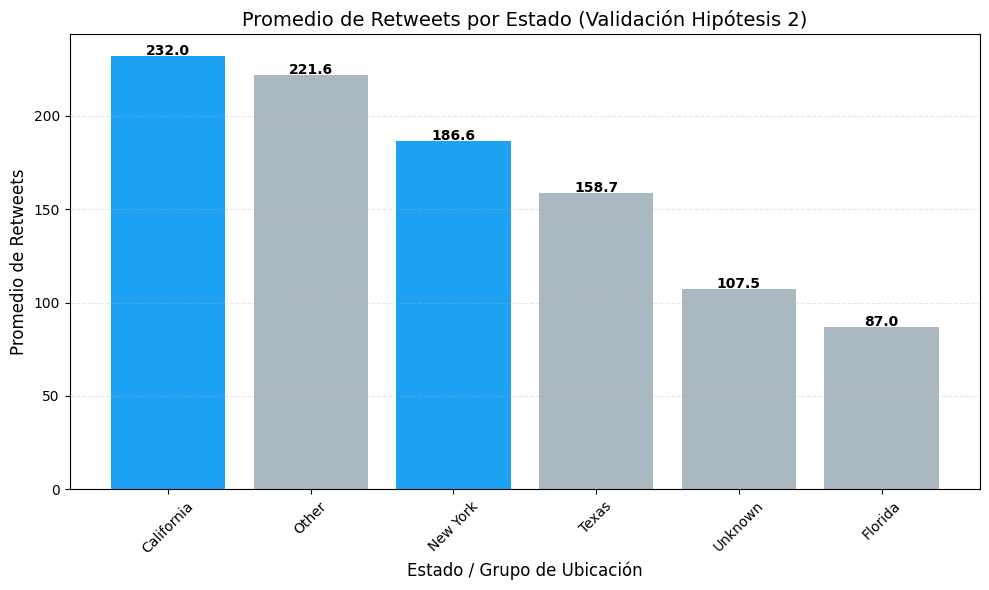

In [18]:
# 1. Realizamos el JOIN y calculamos el promedio de retweets por grupo de estado
df_results = con.execute("""
SELECT 
    u.state_group, 
    ROUND(AVG(t.retweet_count), 1) AS avg_retweets
FROM users_cleaned_location u
JOIN tweets_analysis t ON u.id_str = t.user_id
GROUP BY u.state_group
ORDER BY avg_retweets DESC
""").df()


plt.figure(figsize=(10, 6))
# Usamos colores destacados para los estados de la hipótesis
colors = ['#1DA1F2' if x in ['California', 'New York'] else '#AAB8C2' for x in df_results['state_group']]

plt.bar(df_results['state_group'], df_results['avg_retweets'], color=colors)
plt.title('Promedio de Retweets por Estado (Validación Hipótesis 2)', fontsize=14)
plt.xlabel('Estado / Grupo de Ubicación', fontsize=12)
plt.ylabel('Promedio de Retweets', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Añadimos etiquetas de valor sobre las barras
for i, v in enumerate(df_results['avg_retweets']):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('grafico_hipotesis_ubicacion.png')

# Guardar resultados
df_results.to_csv('resultados_hipotesis_ubicacion.csv', index=False)

#Mostrar resultados
df_results

En el gráfico podemos ver el promedio de retweets por estado, resaltando en color aquellos dos que contempla nuestra hipótesis. A continuación, para comprobar nuestra hipótesis vamos a agrupar todo en dos grupos: Grupo TOP (New York y California) y Grupo Otros (los demás). Haremos las medias ponderadas para cada grupo y ejecutaremos un test estádistico para rechazar o aceptar nuestra hipótesis. 

Comprobación de la no - normalidad de la distribución de los retweets: 

c:\Users\ronge\Desktop\PROGRAMACION\DATA SCIENCE\Proyectos SQL\Análisis de tweets políticos\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


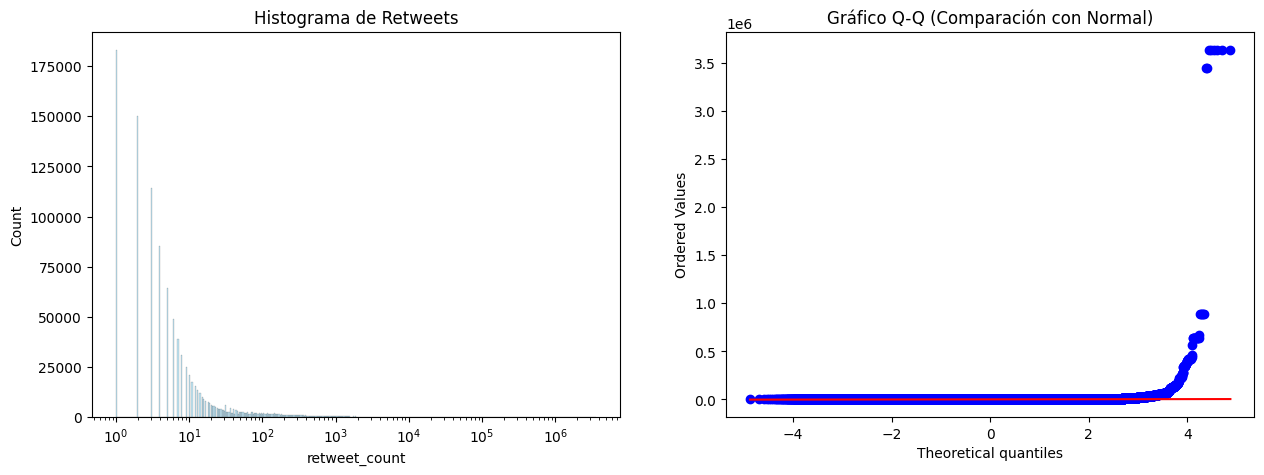

In [19]:
# 1. Creamos los dos grupos de estudio (usando el DataFrame que unimos antes)
df_joined = con.execute("""
    SELECT u.state_group, t.retweet_count 
    FROM users_cleaned_location u
    JOIN tweets_analysis t ON u.id_str = t.user_id
""").df()

# Creamos una figura con dos subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# A. Histograma con curva de densidad
sns.histplot(df_joined['retweet_count'], kde=True, ax=ax1, color='skyblue', log_scale=True)
ax1.set_title('Histograma de Retweets')

# B. Gráfico Q-Q (Quantile-Quantile Plot)
stats.probplot(df_joined['retweet_count'], dist="norm", plot=ax2)
ax2.set_title('Gráfico Q-Q (Comparación con Normal)')

plt.show()

In [20]:

group_top = df_joined[df_joined['state_group'].isin(['California', 'New York'])]['retweet_count']
group_others = df_joined[~df_joined['state_group'].isin(['California', 'New York'])]['retweet_count']


# 2. Ejecución del Test de Mann-Whitney U (No paramétrico)
stat, p_value = stats.mannwhitneyu(group_top, group_others, alternative='greater')

# 3. Cálculo de métricas descriptivas para la comparación
mean_top = group_top.mean()
mean_others = group_others.mean()
diff_percentage = ((mean_top - mean_others) / mean_others) * 100

# 4. Resultados 
print(f"--- RESULTADOS DEL TEST ESTADÍSTICO ---")
print(f"Promedio Grupo Top (CA/NY): {mean_top:.2f}")
print(f"Promedio Grupo Otros: {mean_others:.2f}")
print(f"Diferencia porcentual observada: {diff_percentage:.2f}%")
print(f"Valor p (p-value): {p_value:.10f}")

# 5. Lógica de Aceptación/Rechazo
alpha = 0.05
if p_value < alpha:
    print("\nCONCLUSIÓN: Rechazamos la hipótesis nula (H0).")
    print("La diferencia es ESTADÍSTICAMENTE SIGNIFICATIVA.")
    if diff_percentage >= 30:
        print("La Hipótesis de Ubicación se ACEPTA: El incremento es >= 30%.")
    else:
        print(f"La Hipótesis se ACEPTA PARCIALMENTE: Hay diferencia, pero es del {diff_percentage:.2f}%.")
else:
    print("\nCONCLUSIÓN: No se puede rechazar la hipótesis nula.")
    print("La diferencia observada podría deberse al azar.")


--- RESULTADOS DEL TEST ESTADÍSTICO ---
Promedio Grupo Top (CA/NY): 219.50
Promedio Grupo Otros: 185.56
Diferencia porcentual observada: 18.29%
Valor p (p-value): 0.0000000000

CONCLUSIÓN: Rechazamos la hipótesis nula (H0).
La diferencia es ESTADÍSTICAMENTE SIGNIFICATIVA.
La Hipótesis se ACEPTA PARCIALMENTE: Hay diferencia, pero es del 18.29%.


### Validación de hipótesis de antigüedad

Si recordamos, esta hipótesis hacia referencia a que las cuentas creadas antes del año 2012 poseen una base de seguidores significativamente mayor, independientemente de su frecuencia de posteo actual, debido a la ventaja del "primer movimiento" en la plataforma. 

Para comprobarlo, primero vamos a crear una nueva columna categórica que separe las cuentas que se  crearon antes del 2012 como "Veteran" y a partir del 2012 como "Newcomer". 

In [21]:
# Creación de la nueva columna
con.execute("""CREATE OR REPLACE TABLE users_segment AS
                                SELECT *,
                                        CASE 
                                        WHEN account_creation_date < '2012-01-01' THEN 'Veteran'
                                        ELSE 'Newcomer'
                                    END AS account_segment
                                FROM users_analysis""").df()

# Visualización
df_antiguedad = con.execute("SELECT * FROM users_segment").df()

df_antiguedad.head()

,id_str,screen_name,followers_count,account_creation_date,location,verified,account_segment
0,1009269193,RepLipinski,8061,2012-12-13,None,True,Newcomer
1,1037321378,RepMarkTakano,37430,2012-12-26,"Riverside, CA",True,Newcomer
2,104198706,GovernorVA,56096,2010-01-12,"Richmond, Va",True,Veteran
3,1045110018,RepDanKildee,26164,2012-12-29,"Michigan and Washington, D.C.",True,Newcomer
4,1045853744,RepLukeMesser,10097,2012-12-29,"Shelbyville, IN",True,Newcomer


A continuación, vamos a obtener media y mediana (mas resistente a los outliers) de cada grupo: 

In [22]:
df_antiguedad_2 = con.execute("""SELECT 
                                    account_segment,
                                    COUNT(*) AS total_usuarios,
                                    ROUND(AVG(followers_count), 2) AS promedio_seguidores,
                                    MEDIAN(followers_count) AS mediana_seguidores,
                                    MAX(followers_count) AS max_seguidores -- Útil para ver el outlier más grande
                                FROM users_segment
                                GROUP BY account_segment""").df()


df_antiguedad_2.head()

,account_segment,total_usuarios,promedio_seguidores,mediana_seguidores,max_seguidores
0,Veteran,317,202394.91,22770.0,31712585
1,Newcomer,231,109967.94,8597.0,18545354


A continuación, vamos a representar la distribución de los valores de "followers_count". Lo haremos en formato logaritmo, puesto que sino no podremos visualizar correctamente los datos. 

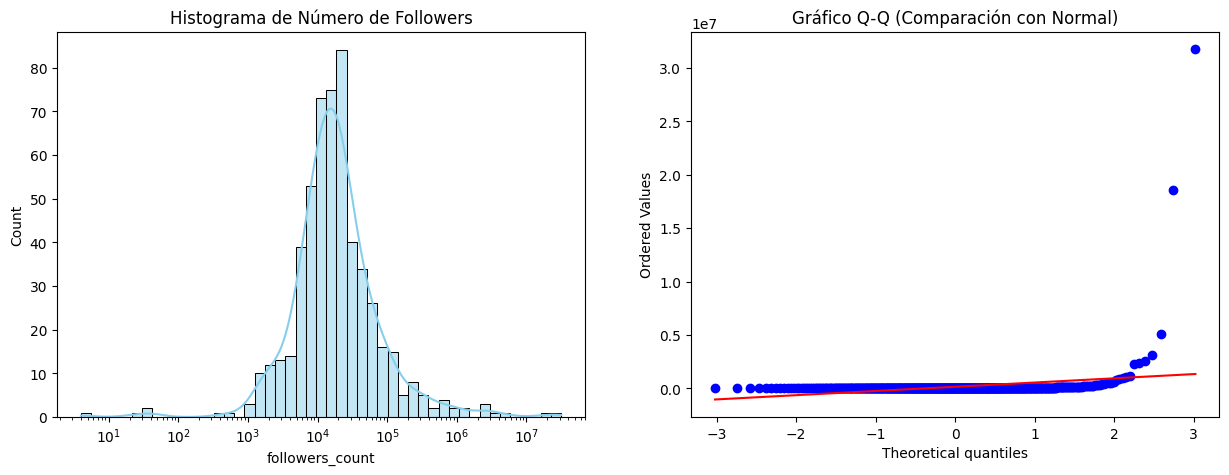

In [23]:
# 1. Creamos los dos grupos de estudio (usando el DataFrame que unimos antes)

# Creamos una figura con dos subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# A. Histograma con curva de densidad
sns.histplot(df_antiguedad['followers_count'], kde=True, ax=ax1, color='skyblue', log_scale=True)
ax1.set_title('Histograma de Número de Followers')

# B. Gráfico Q-Q (Quantile-Quantile Plot)
stats.probplot(df_antiguedad['followers_count'], dist="norm", plot=ax2)
ax2.set_title('Gráfico Q-Q (Comparación con Normal)')

plt.show()

Como vemos, followers_count (log) sigue una distribución normal (o parecida) asi que efectúamos los test pertinentes (paramétricos) para comprobar si rechazamos o acetpamos nuestra hipótesis. 

In [24]:
# 1. Crear la variable logarítmica (usamos log1p para evitar errores con ceros)
df_antiguedad['log_followers'] = np.log1p(df_antiguedad['followers_count'])

# 2. Separar los grupos
vet_log = df_antiguedad[df_antiguedad['account_segment'] == 'Veteran']['log_followers']
new_log = df_antiguedad[df_antiguedad['account_segment'] == 'Newcomer']['log_followers']

# 3. Calcular el T-test de Welch
t_stat, p_value = stats.ttest_ind(vet_log, new_log, equal_var=False)


# 4. Imprimir el valor del p - value
print(f"P-value: {p_value:.10f}")


P-value: 0.0000000000


Como vemos, p - value < 0.05 nos permite rechazar la hipótesis nula y afirmar que existe una diferencia significativa entre la media de los usuarios creados antes de 2012 y los creados a posteriori. 

Por último, visualizamos las categorías: 

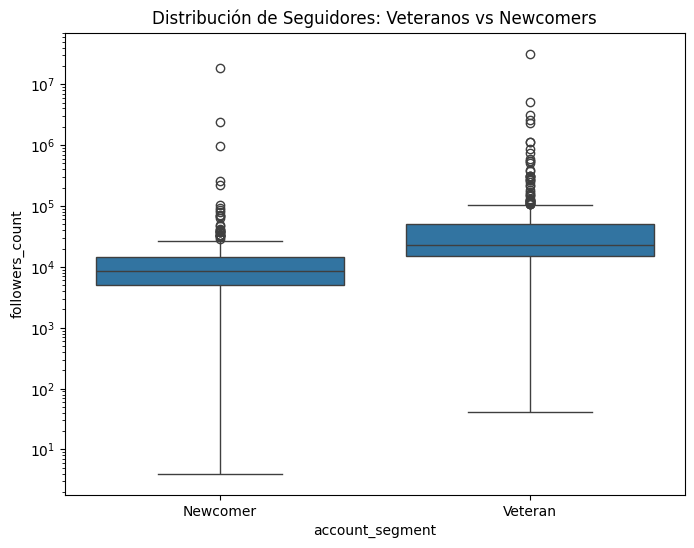

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='account_segment', y='followers_count', data=df_antiguedad)
plt.yscale('log')# <--- ¡ESTO ES VITAL!
plt.title('Distribución de Seguidores: Veteranos vs Newcomers')
plt.show()

### Validación de hipótesis de verificación

Para esta hipótesis vamos a comprobar si las cuentas verificadas mantienen una consistencia de publicación mayor (desviación típica menor en el tiempo entre tweets) que las cuentas no verficadas. 

Para conseguir esto, primero vamos a ordernar los tweets de cada usuario por fecha y calcularemos la diferencia con el tweet anterior. 

In [26]:
# Paso 1: Calculamos el "Gap" o intervalo entre tweets
con.execute("""
CREATE OR REPLACE TABLE tweets_with_gaps AS
SELECT 
    user_id,
    tweet_date,
    -- Obtenemos la fecha del tweet anterior de ese mismo usuario
    LAG(tweet_date) OVER (PARTITION BY user_id ORDER BY tweet_date) AS prev_tweet_date,
    
    -- Calculamos la diferencia en DÍAS (Gap)
    date_diff('day', 
              LAG(tweet_date) OVER (PARTITION BY user_id ORDER BY tweet_date), 
              tweet_date) AS days_gap
              
FROM tweets_analysis
-- Importante: Filtramos fechas nulas para evitar errores
WHERE tweet_date IS NOT NULL;
""")

# Verificamos el resultado visualmente
df_gaps = con.execute("SELECT * FROM tweets_with_gaps").df()
df_gaps.head()

,user_id,tweet_date,prev_tweet_date,days_gap
0,19929362,2017-03-28,2017-03-28,0
1,19929362,2017-03-28,2017-03-28,0
2,19929362,2017-03-28,2017-03-28,0
3,19929362,2017-03-28,2017-03-28,0
4,19929362,2017-03-30,2017-03-28,2


A continuación, vamos a calcular la desviación estándar para cada usuario (usarios con al menos 5 intervalos para no añadir ruido): 

In [27]:
# Paso 2: Agrupamos por usuario para calcular su "Puntuación de Inconsistencia"
con.execute("""
CREATE OR REPLACE TABLE user_consistency_metrics AS
SELECT 
    user_id,
    -- La métrica clave: Desviación Típica de los días de espera
    -- (Más bajo = Más consistente / Más alto = Más errático)
    STDDEV(days_gap) AS gap_std_dev,
    
    -- Métricas de apoyo para contexto
    AVG(days_gap) AS avg_gap_days,   -- ¿Cada cuánto suele publicar?
    COUNT(days_gap) AS num_intervals -- ¿Cuántos saltos hemos medido?
    
FROM tweets_with_gaps
-- Solo consideramos filas donde el gap no sea nulo
WHERE days_gap IS NOT NULL
GROUP BY user_id
-- FILTRO DE CALIDAD: Solo usuarios con historial suficiente (>= 5 intervalos)
HAVING COUNT(days_gap) >= 5;
""")

# Verificamos la tabla resultante
df_consistency = con.execute("SELECT * FROM user_consistency_metrics ORDER BY gap_std_dev ASC").df()
df_consistency.head()

,user_id,gap_std_dev,avg_gap_days,num_intervals
0,510196665,0.166667,0.027778,36
1,14275291,0.275953,0.082280,3245
2,15808765,0.276049,0.079380,3225
3,2962868158,0.285305,0.078293,3257
4,806906355214852096,0.292881,0.090376,1704


Ahora agrupamos los usuarios y sus desviaciones según estén verificados o no para luego realizar el test de significación: 

In [28]:
# Paso 3 y 4: Join y Comparación de Consistencia
df_verification_test = con.execute("""
SELECT 
    u.verified AS es_verificado,
    COUNT(m.user_id) AS total_usuarios,
    
    -- La métrica clave: Mediana de la Desviación Típica
    -- (Usamos mediana para evitar outliers)
    ROUND(MEDIAN(m.gap_std_dev), 2) AS mediana_inconsistencia,
    
    -- Promedio para referencia
    ROUND(AVG(m.gap_std_dev), 2) AS promedio_inconsistencia

FROM user_consistency_metrics m
JOIN users_analysis u ON m.user_id = u.id_str
GROUP BY u.verified
""").df()

display(df_verification_test)

,es_verificado,total_usuarios,mediana_inconsistencia,promedio_inconsistencia
0,False,14,2.52,7.25
1,True,530,1.17,2.22


Un valor menor (tanto en media como en mediana) implica una mayor consistencia a la hora de publicar tweets. Queda realizar el test de significación para demostrar si la diferencia es debido a la verificación o a otros factores que no contemplamos: 

In [29]:
# 1. Extraemos los datos crudos para cada grupo
verified_std = con.execute("""
    SELECT m.gap_std_dev 
    FROM user_consistency_metrics m
    JOIN users_analysis u ON m.user_id = u.id_str
    WHERE u.verified = TRUE
""").df()['gap_std_dev']

non_verified_std = con.execute("""
    SELECT m.gap_std_dev 
    FROM user_consistency_metrics m
    JOIN users_analysis u ON m.user_id = u.id_str
    WHERE u.verified = FALSE
""").df()['gap_std_dev']

# 2. Ejecutamos el Test de Mann-Whitney U
stat, p_value = stats.mannwhitneyu(verified_std, non_verified_std, alternative='less')

# 3. Imprimimos resultados
print(f"--- RESULTADOS DE CONSISTENCIA ---")
print(f"Usuarios Verificados: {len(verified_std)}")
print(f"Usuarios No Verificados: {len(non_verified_std)}")
print(f"\nP-Value: {p_value:.10f}")

# Imprimimos rechazo o aceptación de la hipótesis nula
alpha = 0.05
if p_value < alpha:
    print("\nCONCLUSIÓN: Rechazamos la hipótesis nula.")
    print("La evidencia estadística confirma que las cuentas VERIFICADAS son significativamente")
    print("MÁS CONSISTENTES (menor desviación típica) en su ritmo de publicación.")
else:
    print("\nCONCLUSIÓN: No se puede rechazar la hipótesis nula.")
    print("No hay diferencia significativa en la consistencia de publicación entre grupos.")

--- RESULTADOS DE CONSISTENCIA ---
Usuarios Verificados: 530
Usuarios No Verificados: 14

P-Value: 0.0020032920

CONCLUSIÓN: Rechazamos la hipótesis nula.
La evidencia estadística confirma que las cuentas VERIFICADAS son significativamente
MÁS CONSISTENTES (menor desviación típica) en su ritmo de publicación.


Por último, queda la visualización de los dos grupos: 

C:\Users\ronge\AppData\Local\Temp\ipykernel_30156\3111815040.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='verified', y='gap_std_dev', data=df_plot, palette=['#AAB8C2', '#1DA1F2'])


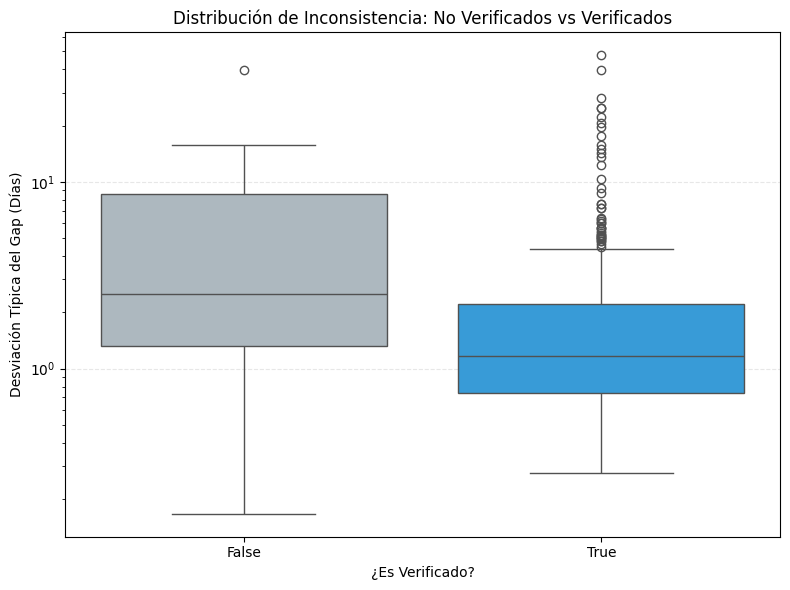

In [30]:
# Preparamos un dataframe conjunto para graficar
df_plot = con.execute("""
    SELECT u.verified, m.gap_std_dev 
    FROM user_consistency_metrics m
    JOIN users_analysis u ON m.user_id = u.id_str
""").df()

plt.figure(figsize=(8, 6))
# Usamos escala logarítmica para ver mejor el gráfico
sns.boxplot(x='verified', y='gap_std_dev', data=df_plot, palette=['#AAB8C2', '#1DA1F2'])

plt.title('Distribución de Inconsistencia: No Verificados vs Verificados')
plt.xlabel('¿Es Verificado?')
plt.ylabel('Desviación Típica del Gap (Días)')
plt.yscale('log') # Escala logarítmica 
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Correlación entre las diferentes variables

Vamos a comprobar que atributos se relacionan más entre ellos y si su relación es lineal. Primero, creamos un mapa de correlación que nos indica el coeficiente de cada una: 

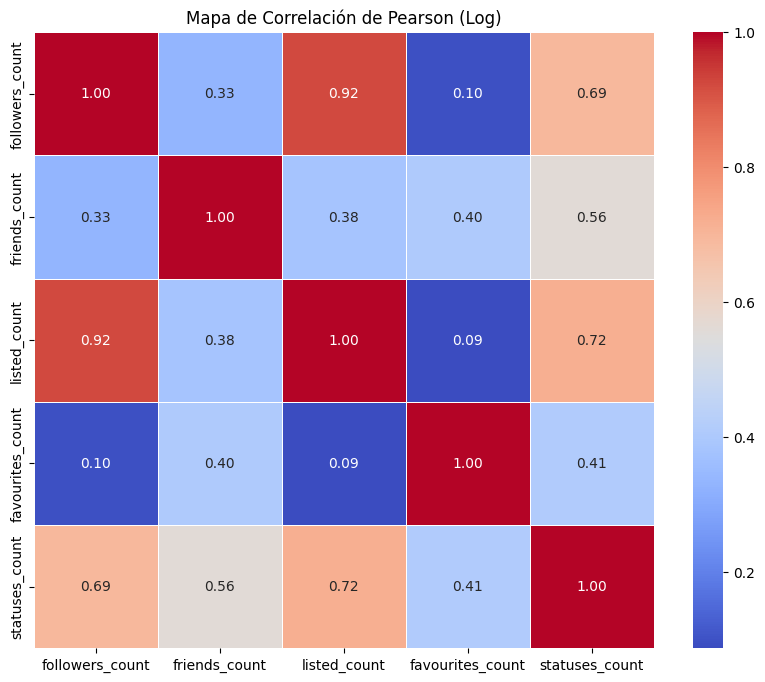

In [31]:
# 1. Seleccionamos las columnas numéricas clave
cols = ['followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']

# 2. Aplicamos Logaritmo (log1p) para normalizar 
df_log = df_users[cols].apply(np.log1p)

# 3. Calculamos la matriz de correlación de Pearson
corr_matrix = df_log.corr(method='pearson')

# 4. Visualización con Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Correlación de Pearson (Log)')
plt.show()

Ahora, seleccionamos las dos variables que más se relacionan y calculamos su regresión, la visualizamos y obtenemos su ecuación: 

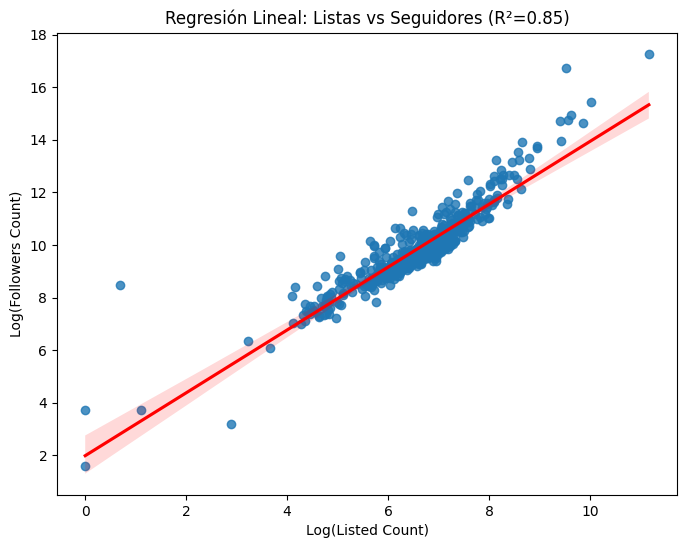

Ecuación: Log(Seguidores) = 1.20 * Log(Listas) + 1.99


In [32]:
# Usamos las variables logarítmicas para la regresión
x = df_log['listed_count']
y = df_log['followers_count']

# Calculamos la regresión
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Gráfico de Regresión
plt.figure(figsize=(8, 6))
sns.regplot(x=x, y=y, line_kws={"color": "red"})
plt.title(f'Regresión Lineal: Listas vs Seguidores (R²={r_value**2:.2f})')
plt.xlabel('Log(Listed Count)')
plt.ylabel('Log(Followers Count)')
plt.show()

print(f"Ecuación: Log(Seguidores) = {slope:.2f} * Log(Listas) + {intercept:.2f}")

### Análisis de las palabras clave según verificación

A continuación, vamos a hacer un analísis del contenido de los tweets, con el objetivo de determinar si existe alguna diferencia de palabras clave o más usadas entre los usuarios verificados y los no verificados: 

In [33]:
# 1. Unir todos los tweets de cada grupo en un solo "texto gigante"
# Vamos a comparar VERIFICADOS vs NO VERIFICADOS
df_text = con.execute("""
    SELECT 
        u.verified,
        STRING_AGG(t.text, ' ') as all_text
    FROM tweets_analysis t
    JOIN users_analysis u ON t.user_id = u.id_str
    GROUP BY u.verified
""").df()

# 2. Aplicar TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=20) # herramienta de scikit-learn
matrix = tfidf.fit_transform(df_text['all_text'])
feature_names = tfidf.get_feature_names_out()

# 3. Mostrar las palabras clave por grupo
dense = matrix.todense()
lst1 = dense[0].tolist()[0]
lst2 = dense[1].tolist()[0]

print("Top palabras clave para NO Verificados:", [feature_names[i] for i in np.argsort(lst1)[::-1][:10]])
print("Top palabras clave para Verificados:", [feature_names[i] for i in np.argsort(lst2)[::-1][:10]])

Top palabras clave para NO Verificados: ['https', 'http', 'rt', 'today', 'amp', 'great', 'thank', 'day', 'thanks', 'new']
Top palabras clave para Verificados: ['https', 'http', 'rt', 'amp', 'today', 'great', 'house', 'new', 'thanks', 'thank']


Por último, vamos a crear dos métricas nuevas: 
- **Reciprocity Ratio** -> Supone la división entre friends_count / followers_count. Si es > 1, el usuario sigue a más gente de la que le sigue y viceversa. Nos servirá para buscar perfiles "celebridad": una gran cantidad de seguidores frente a pocos seguidos. 
- **Engagement Efficiency** -> promedio de retweet / 1000 seguidores. Nos permite buscaer usuarios con calidad de audicencia y contenido: pocos seguidores y muchos retweets. 

In [34]:
# Creamos la tabla con las variables de las que luego sacaremos las métricas
con.execute("""
CREATE OR REPLACE TABLE users_analysis AS
SELECT 
    id_str,
    screen_name,
    followers_count,
    created_at_date AS account_creation_date, 
    location,                                 
    verified,
    friends_count                                   
FROM users_final;
""")

Calcuamos las dos métricas: 

In [35]:
con.execute("""
CREATE OR REPLACE TABLE users_advanced_metrics AS
SELECT 
    u.id_str,
    u.screen_name,
    
    -- Ratio de Reciprocidad 
    CAST(u.friends_count AS FLOAT) / NULLIF(u.followers_count, 0) AS reciprocity_ratio,
    
    --  Impacto Real (Promedio de RTs por cada 1000 seguidores)
    (AVG(t.retweet_count) / NULLIF(u.followers_count, 0)) * 1000 AS engagement_per_1k_followers
    
FROM users_analysis u
JOIN tweets_analysis t ON u.id_str = t.user_id
GROUP BY u.id_str, u.screen_name, u.friends_count, u.followers_count
""")

df_metrics = con.execute("SELECT * FROM users_advanced_metrics ORDER BY engagement_per_1k_followers DESC").df()
df_metrics.head()

,id_str,screen_name,reciprocity_ratio,engagement_per_1k_followers
0,510196665,Rep_Matt_Gaetz,0.000000,4364.864865
1,1240107944,RogerMarshallMD,0.080804,2096.172062
2,816282029276938240,RepKihuen,0.016596,684.062643
3,811313565760163844,SenCortezMasto,0.023157,406.294450
4,818472418620608512,RepAlLawsonJr,0.609009,351.729149
